In [17]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os

In [18]:
# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_palette("husl")

In [19]:
class AlgorithmAnalyzer:
    def __init__(self, data_dir="data"):
        self.data_dir = Path(data_dir)
        self.backtrack_detailed = None
        self.backtrack_summary = None
        self.minconflict_detailed = None
        self.minconflict_summary = None
        
    def load_data(self):
        """加载所有数据文件"""
        try:
            # 加载回溯算法数据
            self.backtrack_detailed = pd.read_csv(self.data_dir / "backtrack_detailed_results.csv")
            self.backtrack_summary = pd.read_csv(self.data_dir / "backtrack_summary.csv")
            
            # 加载最小冲突算法数据
            self.minconflict_detailed = pd.read_csv(self.data_dir / "minconflict_detailed_results.csv")
            self.minconflict_summary = pd.read_csv(self.data_dir / "minconflict_summary.csv")
            
            # 预处理数据 - 确保Success列是布尔值
            self._preprocess_data()
            
            print("数据加载成功!")
            self._print_data_info()
            
        except FileNotFoundError as e:
            print(f"文件未找到: {e}")
            return False
        except Exception as e:
            print(f"加载数据时出错: {e}")
            return False
        return True
    
    def _preprocess_data(self):
        """预处理数据，处理成功率和数据类型"""
        # 处理详细数据中的Success列
        for df in [self.backtrack_detailed, self.minconflict_detailed]:
            if 'Success' in df.columns:
                # 将"Yes"/"No"转换为布尔值
                df['Success'] = df['Success'].map({'Yes': True, 'No': False, 'True': True, 'False': False})
                # 如果有字符串形式的布尔值，也处理
                df['Success'] = df['Success'].astype(bool)
        
        # 确保总结数据中的成功率是数值
        for df in [self.backtrack_summary, self.minconflict_summary]:
            if 'SuccessRate(%)' in df.columns:
                df['SuccessRate(%)'] = pd.to_numeric(df['SuccessRate(%)'], errors='coerce')
    
    def _print_data_info(self):
        """打印数据基本信息"""
        print("\n=== 数据概览 ===")
        print(f"回溯算法 - 详细记录: {len(self.backtrack_detailed)} 行")
        print(f"回溯算法 - 总结记录: {len(self.backtrack_summary)} 行")
        print(f"最小冲突 - 详细记录: {len(self.minconflict_detailed)} 行")
        print(f"最小冲突 - 总结记录: {len(self.minconflict_summary)} 行")
        
        # 计算实际成功率
        print("\n实际成功率统计:")
        for size in sorted(self.backtrack_detailed['Size'].unique()):
            bt_success = self.backtrack_detailed[self.backtrack_detailed['Size'] == size]['Success'].mean() * 100
            mc_success = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]['Success'].mean() * 100
            print(f"  问题规模 {size}: 回溯算法 {bt_success:.1f}%, 最小冲突 {mc_success:.1f}%")
    
    def create_comparison_plots(self):
        """创建性能比较图表"""
        if self.backtrack_summary is None or self.minconflict_summary is None:
            print("请先加载数据!")
            return
        
        # 创建图表
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Backtrack vs MinConflict', fontsize=16, fontweight='bold')
        
        # 1. 平均时间比较
        self._plot_avg_time_comparison(axes[0, 0])
        
        # 2. 最大时间比较
        self._plot_max_time_comparison(axes[0, 1])
        
        # 3. 成功率比较
        self._plot_success_rate_comparison(axes[0, 2])
        
        # 4. 平均内存比较
        self._plot_avg_memory_comparison(axes[1, 0])
        
        # 5. 最大内存比较
        self._plot_max_memory_comparison(axes[1, 1])
        
        # 6. 有效性能比较 (考虑成功率的加权性能)
        self._plot_effective_performance(axes[1, 2])
        
        plt.tight_layout()
        plt.savefig('algorithm_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_avg_time_comparison(self, ax):
        """绘制平均时间比较图"""
        sizes = self.backtrack_summary['Size']
        backtrack_avg_time = self.backtrack_summary['AvgTime(ms)']
        minconflict_avg_time = self.minconflict_summary['AvgTime(ms)']
        
        width = 0.35
        x = np.arange(len(sizes))
        
        ax.bar(x - width/2, backtrack_avg_time, width, label='Backtrack', alpha=0.8)
        ax.bar(x + width/2, minconflict_avg_time, width, label='MinConflict', alpha=0.8)
        
        ax.set_xlabel('Problem Size (N)')
        ax.set_ylabel('Average Time (ms)')
        ax.set_title('Average Execution Time Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(sizes)
        ax.legend()
        
        # 添加数值标签
        for i, v in enumerate(backtrack_avg_time):
            ax.text(i - width/2, v + max(backtrack_avg_time.max() * 0.01, 1), f'{v:.1f}', 
                   ha='center', va='bottom', fontsize=8)
        for i, v in enumerate(minconflict_avg_time):
            ax.text(i + width/2, v + max(minconflict_avg_time.max() * 0.01, 1), f'{v:.1f}', 
                   ha='center', va='bottom', fontsize=8)
    
    def _plot_max_time_comparison(self, ax):
        """绘制最大时间比较图"""
        sizes = self.backtrack_summary['Size']
        backtrack_max_time = self.backtrack_summary['MaxTime(ms)']
        minconflict_max_time = self.minconflict_summary['MaxTime(ms)']
        
        ax.plot(sizes, backtrack_max_time, 'o-', linewidth=2, markersize=8, label='Backtrack')
        ax.plot(sizes, minconflict_max_time, 's-', linewidth=2, markersize=8, label='MinConflict')
        
        ax.set_xlabel('Problem Size (N)')
        ax.set_ylabel('Max Time (ms)')
        ax.set_title('Max Execution Time Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_success_rate_comparison(self, ax):
        """绘制成功率比较图"""
        # 使用实际计算的成功率，而不是总结文件中的
        sizes = sorted(self.backtrack_detailed['Size'].unique())
        backtrack_success_rates = []
        minconflict_success_rates = []
        
        for size in sizes:
            bt_success = self.backtrack_detailed[self.backtrack_detailed['Size'] == size]['Success'].mean() * 100
            mc_success = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]['Success'].mean() * 100
            backtrack_success_rates.append(bt_success)
            minconflict_success_rates.append(mc_success)
        
        width = 0.35
        x = np.arange(len(sizes))
        
        bars1 = ax.bar(x - width/2, backtrack_success_rates, width, label='Backtrack', alpha=0.8)
        bars2 = ax.bar(x + width/2, minconflict_success_rates, width, label='MinConflict', alpha=0.8)
        
        ax.set_xlabel('Problem Size (N)')
        ax.set_ylabel('Success Rate (%)')
        ax.set_title('Algorithm Success Rate Comparison')
        ax.set_ylim(0, 105)
        ax.set_xticks(x)
        ax.set_xticklabels(sizes)
        ax.legend()
        
        # 添加数值标签
        for bar, rate in zip(bars1, backtrack_success_rates):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
        
        for bar, rate in zip(bars2, minconflict_success_rates):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
    
    def _plot_avg_memory_comparison(self, ax):
        """绘制平均内存比较图"""
        sizes = self.backtrack_summary['Size']
        backtrack_avg_mem = self.backtrack_summary['AvgMemory(KB)']
        minconflict_avg_mem = self.minconflict_summary['AvgMemory(KB)']
        
        ax.plot(sizes, backtrack_avg_mem, 'o-', linewidth=2, markersize=8, label='Backtrack')
        ax.plot(sizes, minconflict_avg_mem, 's-', linewidth=2, markersize=8, label='MinConflict')
        
        ax.set_xlabel('Problem Size (N)')
        ax.set_ylabel('Average Memory Usage (KB)')
        ax.set_title('Average Memory Usage Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_max_memory_comparison(self, ax):
        """绘制最大内存比较图"""
        sizes = self.backtrack_summary['Size']
        backtrack_max_mem = self.backtrack_summary['MaxMemory(KB)']
        minconflict_max_mem = self.minconflict_summary['MaxMemory(KB)']
        
        width = 0.35
        x = np.arange(len(sizes))
        
        bars1 = ax.bar(x - width/2, backtrack_max_mem, width, label='Backtrack', alpha=0.8)
        bars2 = ax.bar(x + width/2, minconflict_max_mem, width, label='MinConflict', alpha=0.8)
        
        ax.set_xlabel('Problem Size (N)')
        ax.set_ylabel('Max Memory Usage (KB)')
        ax.set_title('Max Memory Usage Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(sizes)
        ax.legend()
    
    def _plot_effective_performance(self, ax):
        """绘制有效性能比较图（考虑成功率）"""
        sizes = sorted(self.backtrack_detailed['Size'].unique())
        backtrack_effective = []
        minconflict_effective = []
        
        for size in sizes:
            # 计算回溯算法的有效性能（成功率为100%，所以就是平均时间）
            bt_avg_time = self.backtrack_detailed[self.backtrack_detailed['Size'] == size]['Time(ms)'].mean()
            bt_success_rate = self.backtrack_detailed[self.backtrack_detailed['Size'] == size]['Success'].mean()
            bt_effective = bt_avg_time / bt_success_rate if bt_success_rate > 0 else float('inf')
            
            # 计算最小冲突算法的有效性能
            mc_avg_time = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]['Time(ms)'].mean()
            mc_success_rate = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]['Success'].mean()
            mc_effective = mc_avg_time / mc_success_rate if mc_success_rate > 0 else float('inf')
            
            backtrack_effective.append(bt_effective)
            minconflict_effective.append(mc_effective)
        
        # 使用对数坐标，因为时间增长可能是指数级的
        ax.semilogy(sizes, backtrack_effective, 'o-', linewidth=2, markersize=8, label='Backtrack')
        ax.semilogy(sizes, minconflict_effective, 's-', linewidth=2, markersize=8, label='MinConflict')
        
        ax.set_xlabel('Problem Size (N)')
        ax.set_ylabel('Effective Time (ms) - Log Scale')
        ax.set_title('Effective Time Comparison Considering Success Rate')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def create_detailed_analysis(self):
        """Create detailed analysis report, with a focus on success rates"""
        if self.backtrack_detailed is None or self.minconflict_detailed is None:
            print("Please load the data first!")
            return
        
        print("\n=== Detailed Performance Analysis ===")
        
        # Analyze success rate distribution
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Detailed Algorithm Analysis (Focus on Success Rates)', fontsize=16, fontweight='bold')
        
        # 1. 成功率随问题规模变化
        sizes = sorted(self.backtrack_detailed['Size'].unique())
        backtrack_success_rates = []
        minconflict_success_rates = []
        
        for size in sizes:
            bt_success = self.backtrack_detailed[self.backtrack_detailed['Size'] == size]['Success'].mean() * 100
            mc_success = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]['Success'].mean() * 100
            backtrack_success_rates.append(bt_success)
            minconflict_success_rates.append(mc_success)
        
        axes[0, 0].plot(sizes, backtrack_success_rates, 'o-', linewidth=2, markersize=8, label='Backtrack')
        axes[0, 0].plot(sizes, minconflict_success_rates, 's-', linewidth=2, markersize=8, label='MinConflict')
        axes[0, 0].set_xlabel('Problem Size (N)')
        axes[0, 0].set_ylabel('Success Rate (%)')
        axes[0, 0].set_title('Success Rate vs Problem Size')
        axes[0, 0].set_ylim(0, 105)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Distribution of Time for Success and Failure Cases
        success_times_bt = self.backtrack_detailed[self.backtrack_detailed['Success'] == True]['Time(ms)']
        success_times_mc = self.minconflict_detailed[self.minconflict_detailed['Success'] == True]['Time(ms)']
        fail_times_mc = self.minconflict_detailed[self.minconflict_detailed['Success'] == False]['Time(ms)']
        
        time_data = [success_times_bt, success_times_mc]
        time_labels = ['Success Backtrack', 'Success MinConflict']
        
        if len(fail_times_mc) > 0:
            time_data.append(fail_times_mc)
            time_labels.append('Failure MinConflict')
        
        axes[0, 1].boxplot(time_data, labels=time_labels)
        axes[0, 1].set_title('Distribution of Time for Success and Failure Cases')
        axes[0, 1].set_ylabel('Time (ms)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. Distribution of Memory for Success and Failure Cases
        success_mem_bt = self.backtrack_detailed[self.backtrack_detailed['Success'] == True]['Memory(KB)']
        success_mem_mc = self.minconflict_detailed[self.minconflict_detailed['Success'] == True]['Memory(KB)']
        fail_mem_mc = self.minconflict_detailed[self.minconflict_detailed['Success'] == False]['Memory(KB)']
        
        mem_data = [success_mem_bt, success_mem_mc]
        mem_labels = ['Success Backtrack', 'Success MinConflict']
        
        if len(fail_mem_mc) > 0:
            mem_data.append(fail_mem_mc)
            mem_labels.append('Failure MinConflict')
        
        axes[1, 0].boxplot(mem_data, labels=mem_labels)
        axes[1, 0].set_title('Memory Distribution for Success and Failure Cases')
        axes[1, 0].set_ylabel('Memory (KB)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # 4. Performance-Success Rate Tradeoff Analysis
        # Calculate performance-success rate tradeoff for each algorithm at each problem size
        bt_tradeoff = []
        mc_tradeoff = []
        
        for size in sizes:
            bt_time = self.backtrack_detailed[self.backtrack_detailed['Size'] == size]['Time(ms)'].mean()
            bt_success = self.backtrack_detailed[self.backtrack_detailed['Size'] == size]['Success'].mean() * 100
            mc_time = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]['Time(ms)'].mean()
            mc_success = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]['Success'].mean() * 100
            
            # 使用时间与(100-成功率)的乘积作为权衡指标
            # 值越小表示性能越好（时间短且成功率高）
            bt_tradeoff.append(bt_time * (100 - bt_success) / 100)
            mc_tradeoff.append(mc_time * (100 - mc_success) / 100)
        
        x = np.arange(len(sizes))
        width = 0.35
        
        axes[1, 1].bar(x - width/2, bt_tradeoff, width, label='Backtrack', alpha=0.8)
        axes[1, 1].bar(x + width/2, mc_tradeoff, width, label='MinConflict', alpha=0.8)
        
        axes[1, 1].set_xlabel('Problem Size (N)')
        axes[1, 1].set_ylabel('Performance-Success Rate Tradeoff')
        axes[1, 1].set_title('Performance-Success Rate Tradeoff Analysis\n(Lower is Better)')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(sizes)
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.savefig('detailed_analysis_with_success_rate.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 打印统计摘要
        self._print_statistical_summary()
    
    def _print_statistical_summary(self):
        """打印统计摘要，特别关注成功率"""
        print("\n=== 统计摘要 ===")
        
        for size in sorted(self.backtrack_detailed['Size'].unique()):
            bt_data = self.backtrack_detailed[self.backtrack_detailed['Size'] == size]
            mc_data = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]
            
            bt_success_rate = bt_data['Success'].mean() * 100
            mc_success_rate = mc_data['Success'].mean() * 100
            
            bt_success_times = bt_data[bt_data['Success'] == True]['Time(ms)']
            mc_success_times = mc_data[mc_data['Success'] == True]['Time(ms)']
            
            print(f"\n问题规模 N={size}:")
            print(f"  回溯算法 - 成功率: {bt_success_rate:.1f}%")
            print(f"  最小冲突 - 成功率: {mc_success_rate:.1f}%")
            
            if len(bt_success_times) > 0:
                print(f"  回溯算法 - 成功案例平均时间: {bt_success_times.mean():.2f}ms")
            if len(mc_success_times) > 0:
                print(f"  最小冲突 - 成功案例平均时间: {mc_success_times.mean():.2f}ms")
            
            # 计算有效性能比
            if mc_success_rate > 0:
                effective_ratio = (bt_success_times.mean() if len(bt_success_times) > 0 else 0) / \
                                 (mc_success_times.mean() if len(mc_success_times) > 0 else float('inf'))
                print(f"  成功案例性能比 (回溯/最小冲突): {effective_ratio:.2f}x")
    
    def create_success_failure_analysis(self):
        """专门分析成功和失败案例的特征"""
        if self.minconflict_detailed is None:
            print("请先加载数据!")
            return
        
        # 只分析最小冲突算法，因为回溯算法成功率是100%
        mc_success = self.minconflict_detailed[self.minconflict_detailed['Success'] == True]
        mc_failure = self.minconflict_detailed[self.minconflict_detailed['Success'] == False]
        
        if len(mc_failure) == 0:
            print("最小冲突算法没有失败案例!")
            return
        
        print(f"\n=== 最小冲突算法失败案例分析 ===")
        print(f"总测试案例: {len(self.minconflict_detailed)}")
        print(f"成功案例: {len(mc_success)} ({len(mc_success)/len(self.minconflict_detailed)*100:.1f}%)")
        print(f"失败案例: {len(mc_failure)} ({len(mc_failure)/len(self.minconflict_detailed)*100:.1f}%)")
        
        # 按问题规模分析失败率
        print("\n按问题规模的失败率:")
        for size in sorted(self.minconflict_detailed['Size'].unique()):
            size_data = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]
            failure_rate = (size_data['Success'] == False).mean() * 100
            print(f"  问题规模 {size}: {failure_rate:.1f}%")
        
        # 创建失败案例分析图
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('MinConflict Failure Case Analysis', fontsize=16, fontweight='bold')
        
        # 1. 失败率随问题规模变化
        sizes = sorted(self.minconflict_detailed['Size'].unique())
        failure_rates = []
        
        for size in sizes:
            size_data = self.minconflict_detailed[self.minconflict_detailed['Size'] == size]
            failure_rate = (size_data['Success'] == False).mean() * 100
            failure_rates.append(failure_rate)
        
        axes[0, 0].bar(sizes, failure_rates, alpha=0.7)
        axes[0, 0].set_xlabel('Problem Size (N)')
        axes[0, 0].set_ylabel('Failure Rate (%)')
        axes[0, 0].set_title('Failure Rate vs. Problem Size')
        
        # 2. 成功与失败案例的时间分布
        time_data = [mc_success['Time(ms)'], mc_failure['Time(ms)']]
        time_labels = ['Successful Cases', 'Failure Cases']
        
        axes[0, 1].boxplot(time_data, labels=time_labels)
        axes[0, 1].set_ylabel('Time (ms)')
        axes[0, 1].set_title('Time Distribution of Successful vs. Failure Cases')
        
        # 3. 成功与失败案例的内存分布
        mem_data = [mc_success['Memory(KB)'], mc_failure['Memory(KB)']]
        mem_labels = ['Successful Cases', 'Failure Cases']
        
        axes[1, 0].boxplot(mem_data, labels=mem_labels)
        axes[1, 0].set_ylabel('Memory (KB)')
        axes[1, 0].set_title('Memory Distribution of Successful vs. Failure Cases')
        
        # 4. 失败案例的累积分布
        if len(mc_failure) > 0:
            sorted_fail_times = np.sort(mc_failure['Time(ms)'])
            y = np.arange(1, len(sorted_fail_times)+1) / len(sorted_fail_times)
            axes[1, 1].plot(sorted_fail_times, y, marker='.', linestyle='none')
            axes[1, 1].set_xlabel('Failure Time (ms)')
            axes[1, 1].set_ylabel('Cumulative Proportion')
            axes[1, 1].set_title('Cumulative Distribution of Failure Case Times')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('minconflict_failure_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

In [20]:
def main():
    """主函数"""
    analyzer = AlgorithmAnalyzer("data")
    
    # 加载数据
    if not analyzer.load_data():
        print("数据加载失败，请检查文件路径!")
        return
    
    # 创建性能比较图表
    analyzer.create_comparison_plots()
    
    # 创建详细分析
    analyzer.create_detailed_analysis()
    
    # 专门分析失败案例
    analyzer.create_success_failure_analysis()
    
    print("\n分析完成！图表已保存为 PNG 文件。")

数据加载成功!

=== 数据概览 ===
回溯算法 - 详细记录: 200 行
回溯算法 - 总结记录: 4 行
最小冲突 - 详细记录: 200 行
最小冲突 - 总结记录: 4 行

实际成功率统计:
  问题规模 4: 回溯算法 100.0%, 最小冲突 100.0%
  问题规模 8: 回溯算法 100.0%, 最小冲突 100.0%
  问题规模 12: 回溯算法 100.0%, 最小冲突 92.0%
  问题规模 16: 回溯算法 100.0%, 最小冲突 88.0%


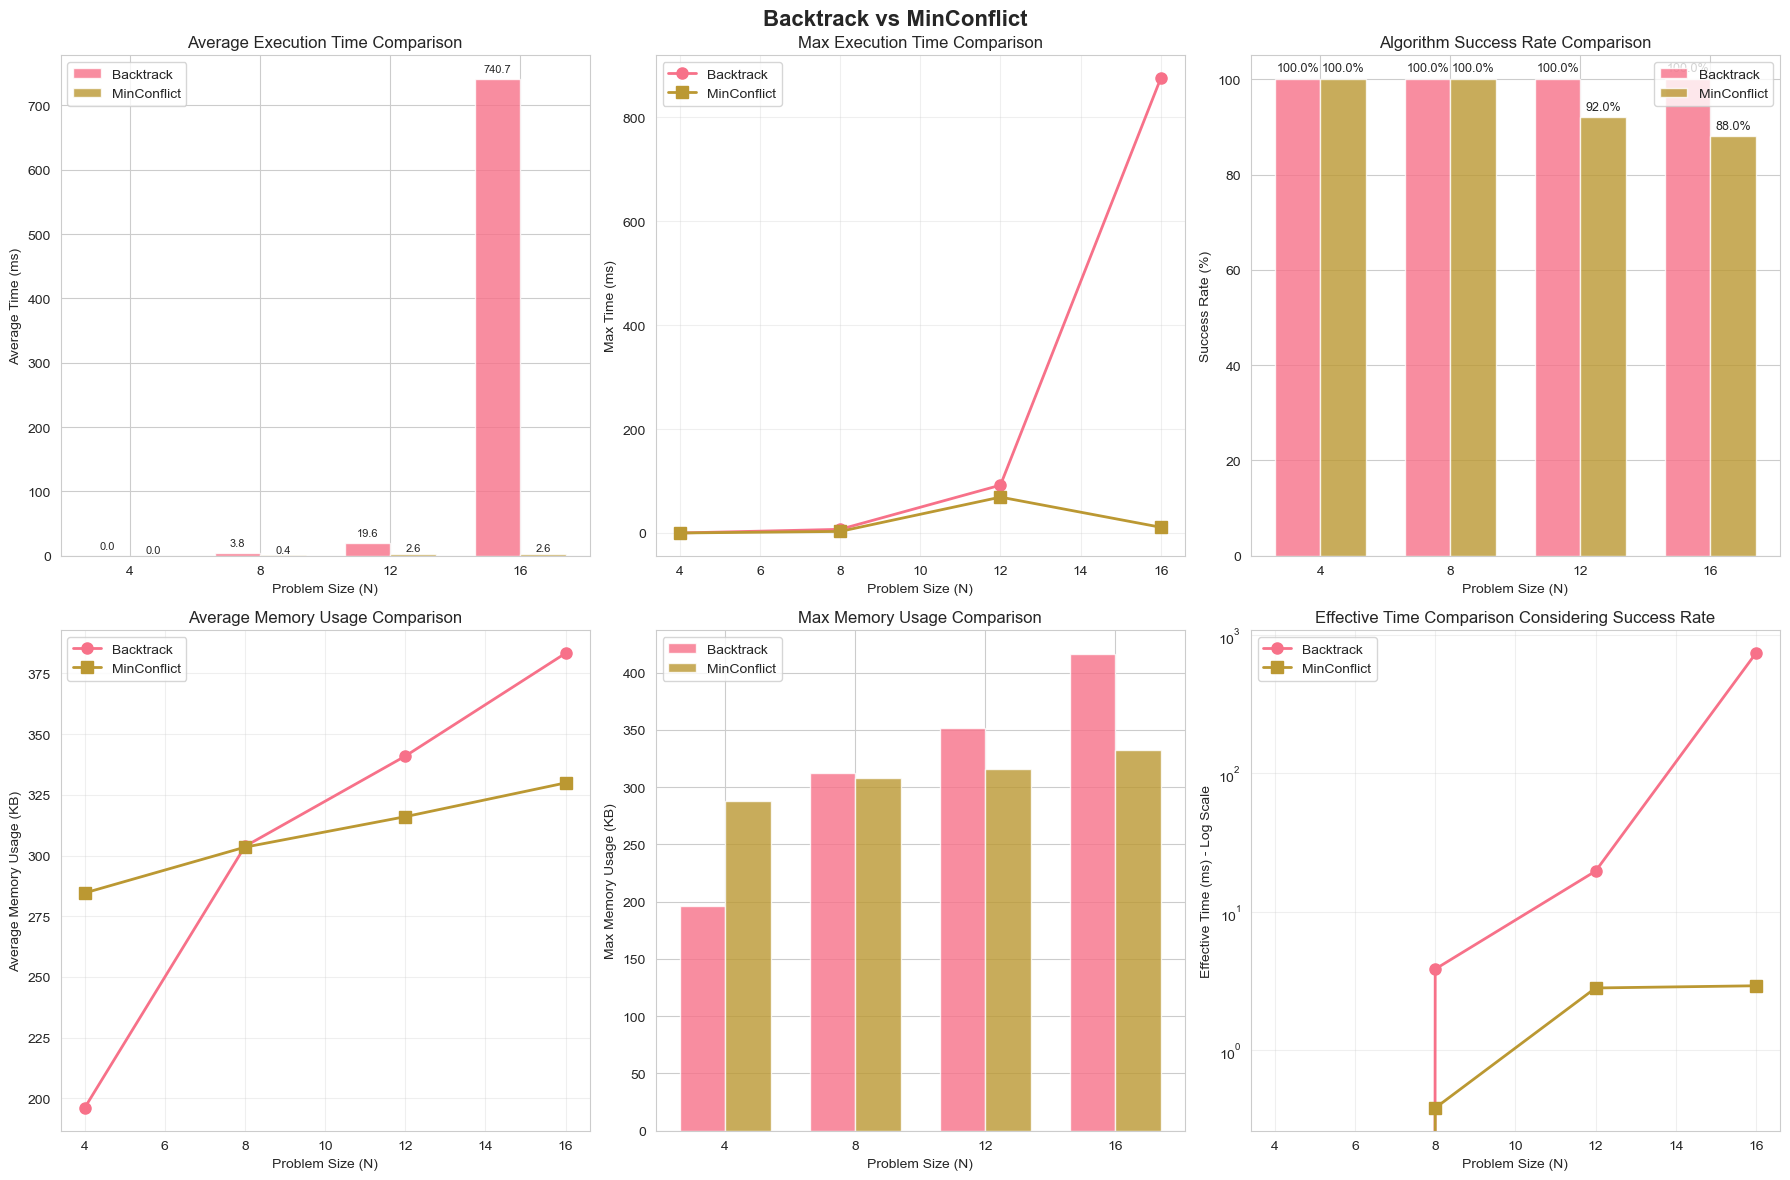


=== Detailed Performance Analysis ===


C:\Users\CYM\AppData\Local\Temp\ipykernel_24384\1047736921.py:284: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(time_data, labels=time_labels)
C:\Users\CYM\AppData\Local\Temp\ipykernel_24384\1047736921.py:301: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(mem_data, labels=mem_labels)


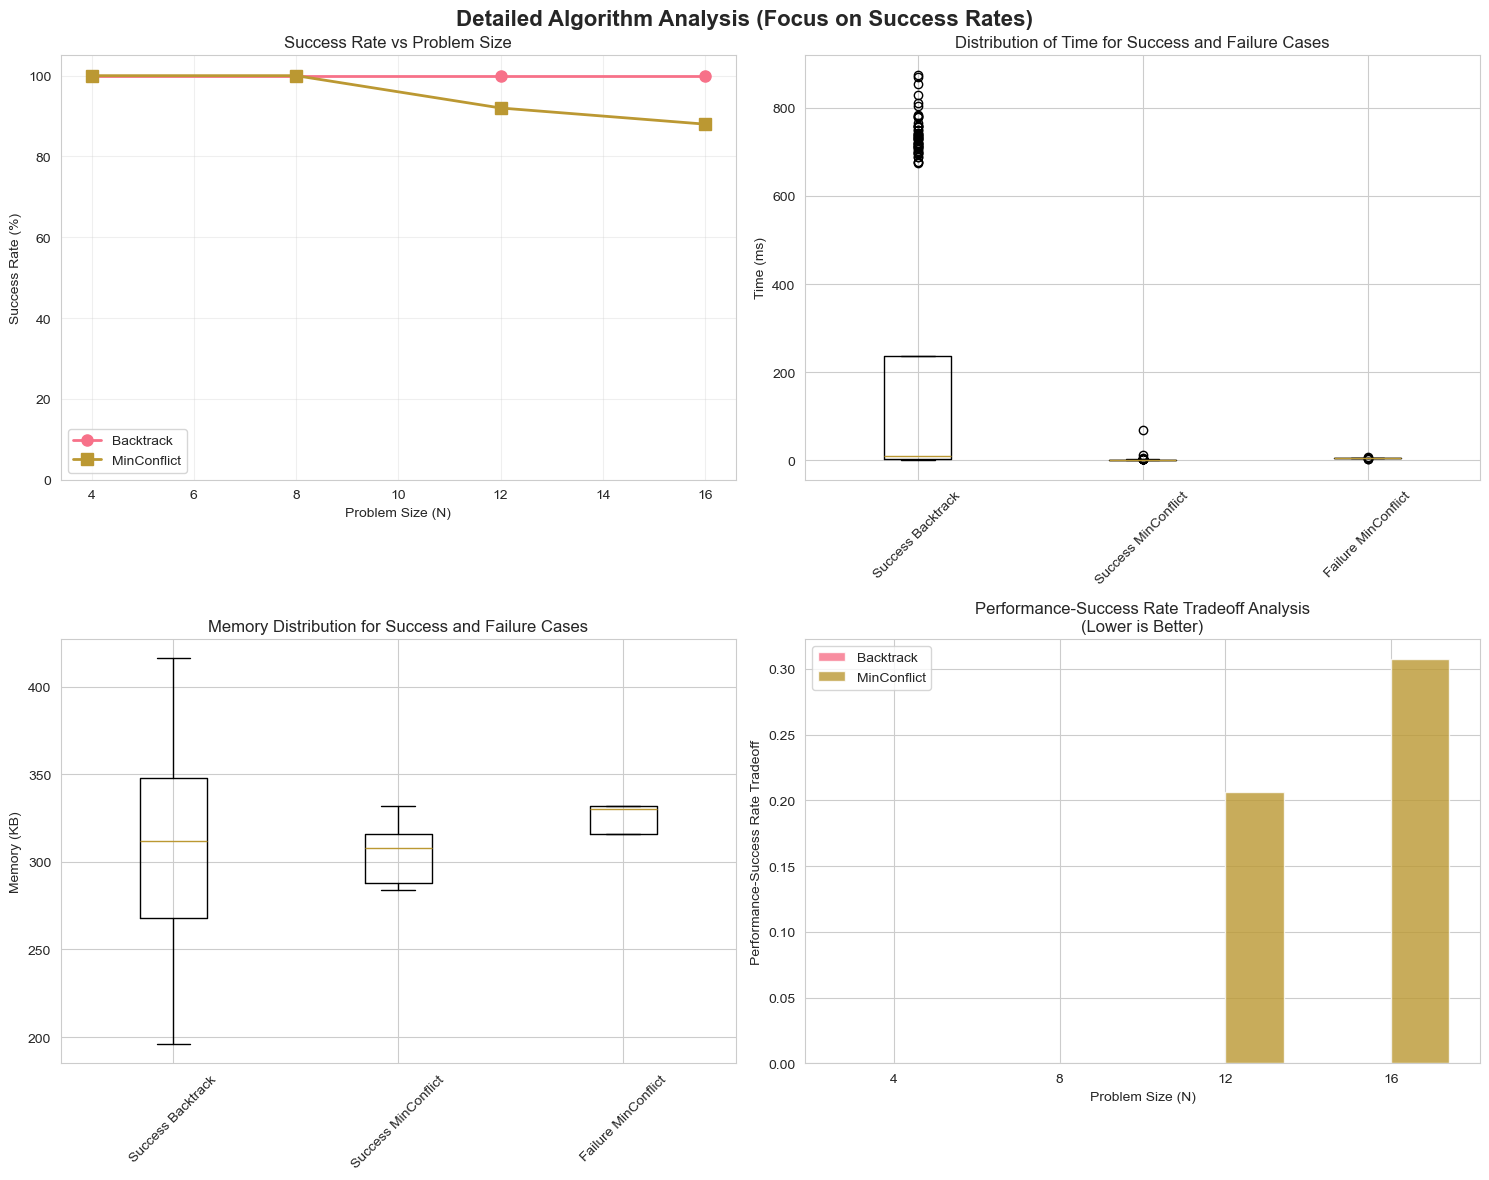


=== 统计摘要 ===

问题规模 N=4:
  回溯算法 - 成功率: 100.0%
  最小冲突 - 成功率: 100.0%
  回溯算法 - 成功案例平均时间: 0.00ms
  最小冲突 - 成功案例平均时间: 0.00ms
  成功案例性能比 (回溯/最小冲突): nanx

问题规模 N=8:
  回溯算法 - 成功率: 100.0%
  最小冲突 - 成功率: 100.0%
  回溯算法 - 成功案例平均时间: 3.84ms
  最小冲突 - 成功案例平均时间: 0.38ms
  成功案例性能比 (回溯/最小冲突): 10.11x

问题规模 N=12:
  回溯算法 - 成功率: 100.0%
  最小冲突 - 成功率: 92.0%
  回溯算法 - 成功案例平均时间: 19.64ms
  最小冲突 - 成功案例平均时间: 2.41ms
  成功案例性能比 (回溯/最小冲突): 8.14x

问题规模 N=16:
  回溯算法 - 成功率: 100.0%
  最小冲突 - 成功率: 88.0%
  回溯算法 - 成功案例平均时间: 740.74ms
  最小冲突 - 成功案例平均时间: 2.16ms
  成功案例性能比 (回溯/最小冲突): 343.08x

=== 最小冲突算法失败案例分析 ===
总测试案例: 200
成功案例: 190 (95.0%)
失败案例: 10 (5.0%)

按问题规模的失败率:
  问题规模 4: 0.0%
  问题规模 8: 0.0%
  问题规模 12: 8.0%
  问题规模 16: 12.0%


C:\Users\CYM\AppData\Local\Temp\ipykernel_24384\1047736921.py:367: RuntimeWarning: invalid value encountered in scalar divide
  effective_ratio = (bt_success_times.mean() if len(bt_success_times) > 0 else 0) / \
C:\Users\CYM\AppData\Local\Temp\ipykernel_24384\1047736921.py:419: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(time_data, labels=time_labels)
C:\Users\CYM\AppData\Local\Temp\ipykernel_24384\1047736921.py:427: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(mem_data, labels=mem_labels)


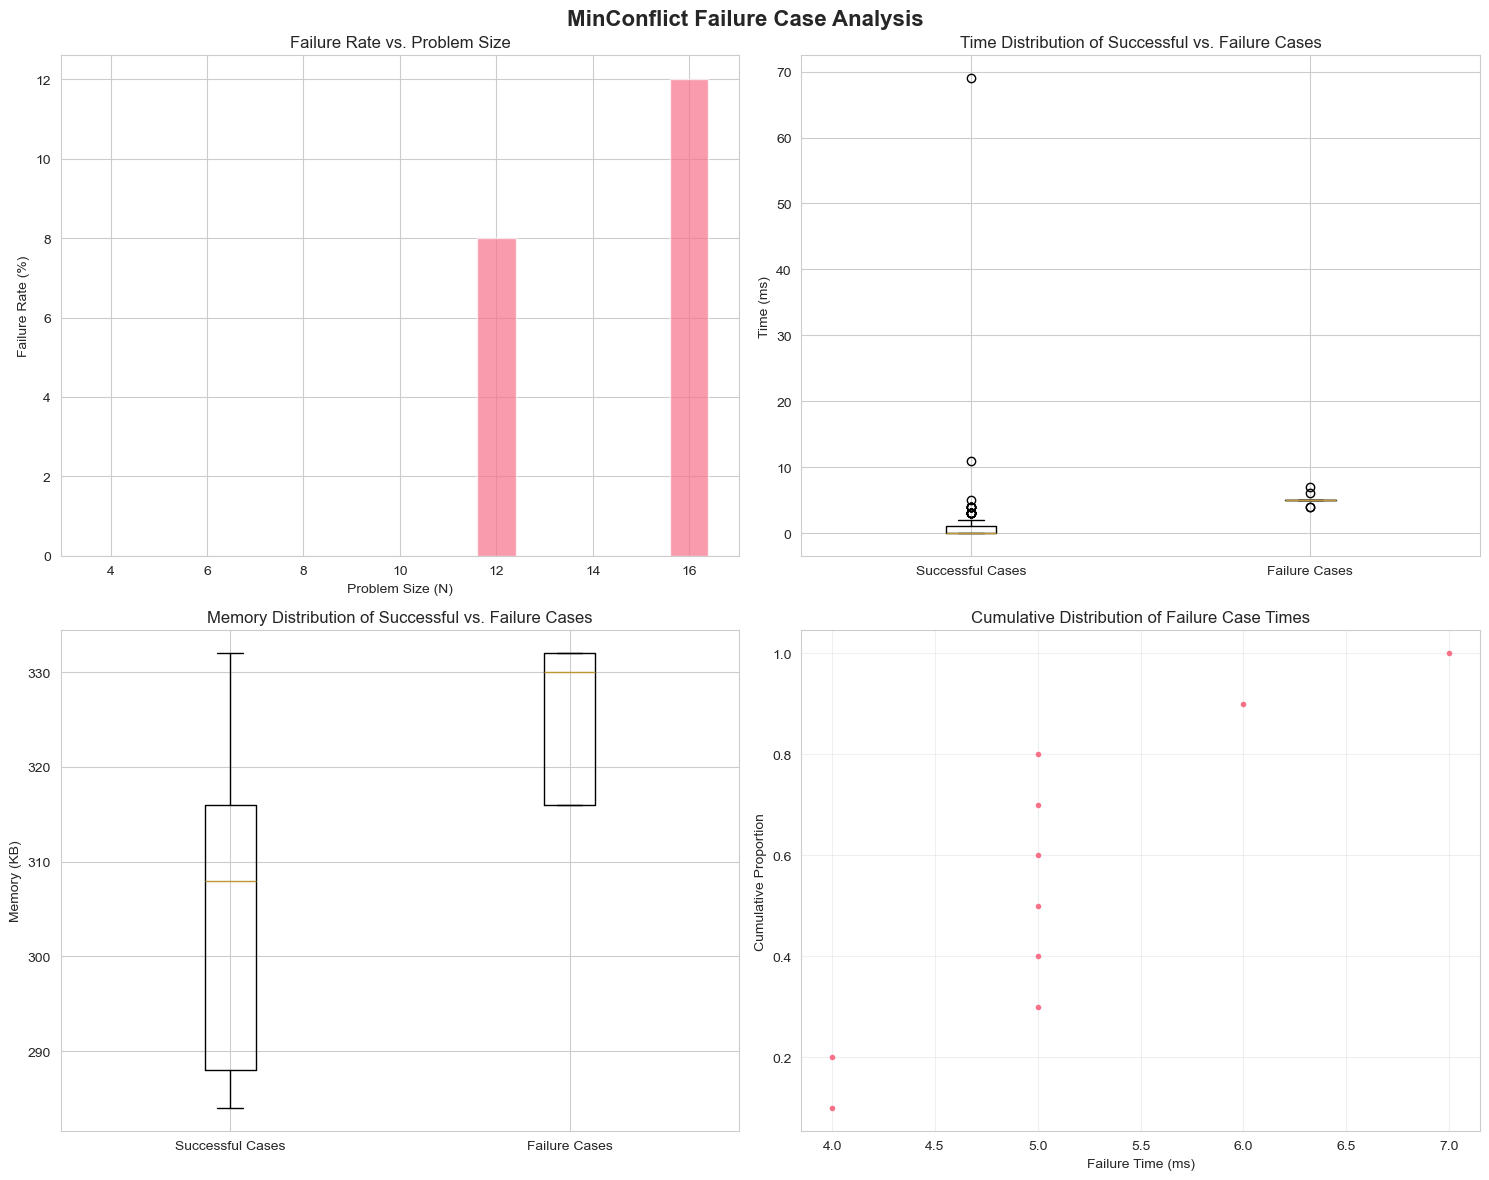


分析完成！图表已保存为 PNG 文件。


In [21]:
if __name__ == "__main__":
    main()